### Import-import library

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

### Load Data

In [2]:
# Define the path to the CSV file
data_path = os.path.join(os.getcwd(), '..', '..', 'data', 'preprocessed_data.csv')

# Load the dataset
df = pd.read_csv(data_path)

In [3]:
# mendefinisi kolom yang memprediksi (xcol) dan diprediksi (ycol) 
ycol = df['average_daily_rate'] 
xcol = df.drop(columns=['property_name', 'room_id', 'average_daily_rate'])

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(xcol, ycol, test_size=0.2, random_state=42)

### Baseline RandomForestRegressor

In [4]:
# menggunakan RandomForestRegressor dengan parameter terbaik
rf_regressor = RandomForestRegressor(
    n_jobs=-1
)

# print parameters
print("Parameters used by RandomForestRegressor:")
for param, value in rf_regressor.get_params().items():
    print(f"{param}: {value}")

# train model
rf_regressor.fit(x_train, y_train)

# prediksi di test set
y_pred_train = rf_regressor.predict(x_train)
y_pred_test = rf_regressor.predict(x_test)

Parameters used by RandomForestRegressor:
bootstrap: True
ccp_alpha: 0.0
criterion: squared_error
max_depth: None
max_features: 1.0
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: -1
oob_score: False
random_state: None
verbose: 0
warm_start: False


Training MAE: 13364.784655548772
Test MAE: 22679.81056389938


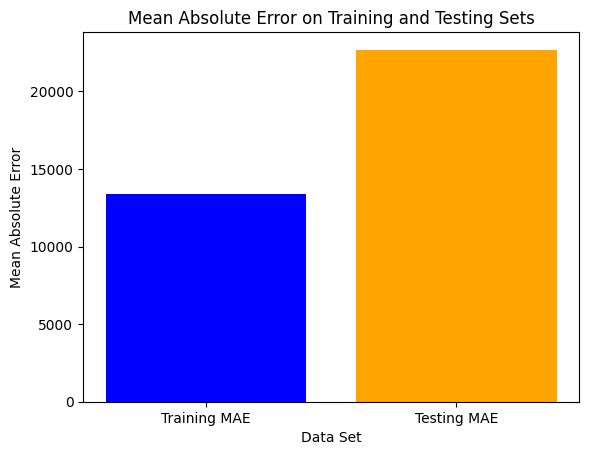

In [5]:
# Evaluasi model menggunakan MAE
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f'Training MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

# Plot  MAE
mae_values = [train_mae, test_mae]
labels = ['Training MAE', 'Testing MAE']

plt.bar(labels, mae_values, color=['blue', 'orange'])
plt.xlabel('Data Set')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error on Training and Testing Sets')
plt.show()

### RandomForestRegressor dengan Grid Search


In [6]:
from sklearn.model_selection import GridSearchCV

# Definisikan model
rf_regressor_tuned = RandomForestRegressor(random_state=42)

# Definisikan grid parameter
param_grid = {
    'n_estimators': [90, 100, 110],
    'max_features': [1, 2, 3],
    'max_depth' : [10,20,30],
    'min_samples_split' : [2,3,4],
    'min_samples_leaf' : [1,2,3],
    'bootstrap': [True, False]
}

# Atur Grid Search
grid_search_rf = GridSearchCV(estimator=rf_regressor_tuned, 
                              param_grid=param_grid, 
                              scoring='neg_mean_absolute_error', 
                              cv=5, 
                              verbose=2, 
                              n_jobs=-1)

# Fit Grid Search
grid_search_rf.fit(x_train, y_train)

# Dapatkan parameter terbaik dan skor terbaik
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print(f'Parameter Terbaik: {best_params_rf}')
print(f'Error Mutlak Rata-rata Terbaik: {-best_score_rf}')


Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Parameter Terbaik: {'bootstrap': False, 'max_depth': 30, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 110}
Error Mutlak Rata-rata Terbaik: 42704.95264668149


In [6]:
# menggunakan RandomForestRegressor dengan parameter terbaik
rf_regressor = RandomForestRegressor(
    bootstrap=False,
    max_depth=30,
    max_features=3,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=110,
    n_jobs=-1
)

# train model
rf_regressor.fit(x_train, y_train)

# prediksi di test set
y_pred_train = rf_regressor.predict(x_train)
y_pred_test = rf_regressor.predict(x_test)

Training MAE: 10479.980282726265
Test MAE: 34579.4690998909


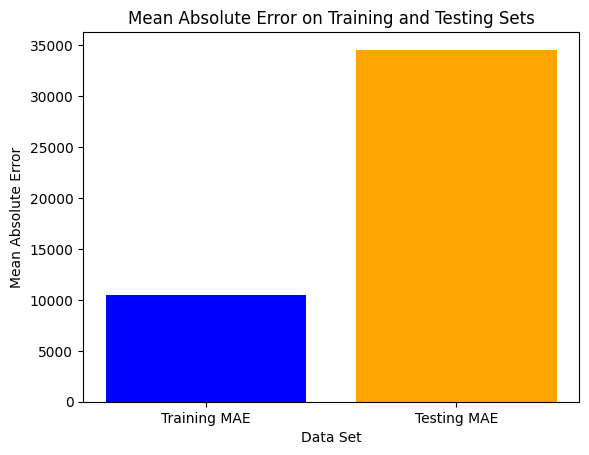

In [7]:
# Evaluate the model using MAE
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f'Training MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

# Plot  MAE
mae_values = [train_mae, test_mae]
labels = ['Training MAE', 'Testing MAE']

plt.bar(labels, mae_values, color=['blue', 'orange'])
plt.xlabel('Data Set')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error on Training and Testing Sets')
plt.show()

### Cross Validation


In [8]:
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score

# Define your RandomForestRegressor model
rf_regressor_cv = RandomForestRegressor(
    n_estimators=110,
    random_state=42,
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=2,
    bootstrap=False,
    n_jobs=-1
)

# Define the k-fold cross-validation scheme
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring function
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Perform cross-validation and get scores
cv_scores = cross_val_score(rf_regressor_cv, x_train, y_train, cv=kf, scoring=scorer)

# Convert negative MAE to positive since we used greater_is_better=False
cv_scores = -cv_scores

# Print the cross-validation scores and their mean
print(f'Cross-Validation MAE Scores: {cv_scores}')
print(f'Mean Cross-Validation MAE: {np.mean(cv_scores)}')

# Fit the model on the entire training data
rf_regressor_cv.fit(x_train, y_train)

# Make predictions on the test data
y_pred_test_cv = rf_regressor_cv.predict(x_test)

# Evaluate the model on the test data
testing_mae_cv = mean_absolute_error(y_test, y_pred_test_cv)
print(f'Mean Absolute Error on Testing: {testing_mae_cv}')


Cross-Validation MAE Scores: [43111.76235634 43607.65995846 41951.69687514 44875.95549506
 44190.26098785]
Mean Cross-Validation MAE: 43547.46713457203
Mean Absolute Error on Testing: 34928.768646395954


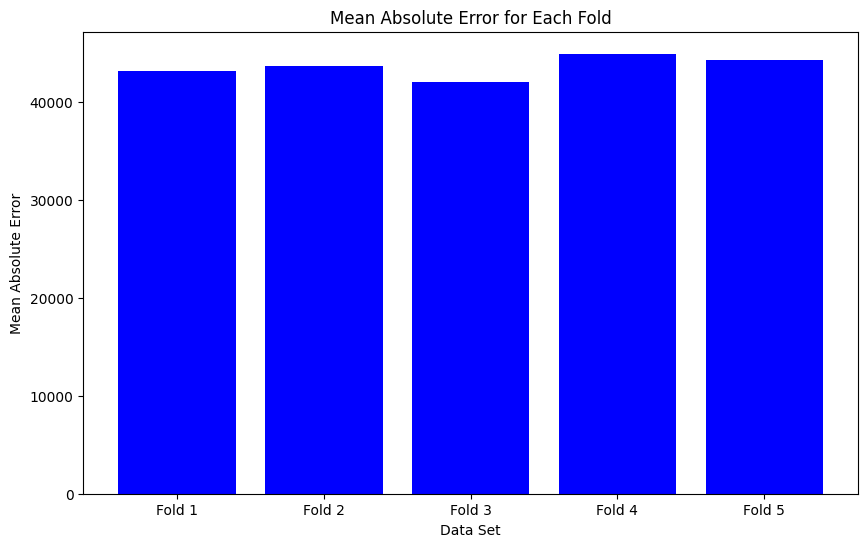

In [9]:
# Plotting the MAE for each fold and the test set
fold_labels = [f'Fold {i+1}' for i in range(len(cv_scores))]

mae_values = list(cv_scores)

plt.figure(figsize=(10, 6))
plt.bar(fold_labels, mae_values, color=['blue']*len(cv_scores))
plt.xlabel('Data Set')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error for Each Fold')
plt.show()

### Tampilkan variabel-variabel penting

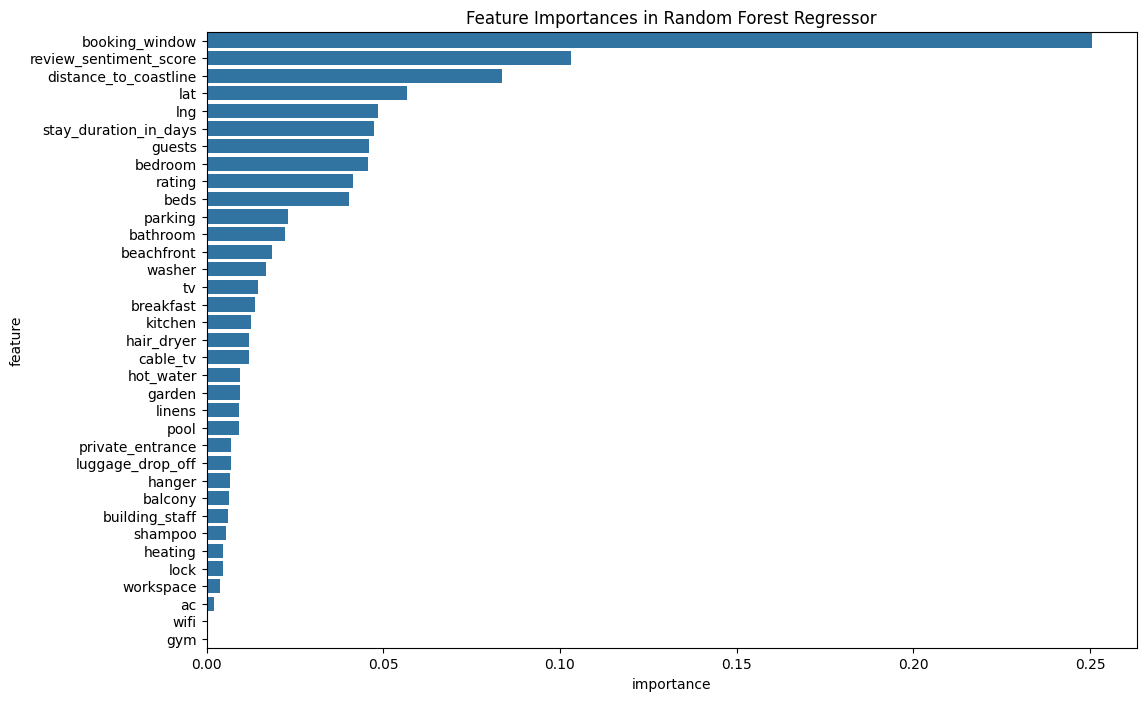

In [10]:
# Get feature importances
feature_importances = rf_regressor.feature_importances_

# Create a DataFrame for visualization
feature_importances_df = pd.DataFrame({
    'feature': xcol.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_df)
plt.title('Feature Importances in Random Forest Regressor')
plt.show()

### RandomForestRegressor dengan Parameter Terbaik dan 7 Fitur Paling Penting


##### definisi ulang xcol

In [4]:
# mendefinisi kolom yang memprediksi (xcol) dan diprediksi (ycol) 
xcol = df[['stay_duration_in_days', 
'booking_window', 
'distance_to_coastline', 
'lat',
'review_sentiment_score', 
'lng', 
'rating']]

# Split data menjadi set training dan testing
x_train, x_test, y_train, y_test = train_test_split(xcol, ycol, test_size=0.2, random_state=42)

##### buat ulang RandomForestRegressor

In [5]:
# menggunakan RandomForestRegressor dengan parameter terbaik
rf_regressor = RandomForestRegressor(
    max_depth=30,
    max_features=3,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=110,
    bootstrap=False,
    n_jobs=-1
)

# train model
rf_regressor.fit(x_train, y_train)

# prediksi di test set
y_pred_train = rf_regressor.predict(x_train)
y_pred_test = rf_regressor.predict(x_test)

Training MAE: 9627.901640669528
Test MAE: 14711.419304556915


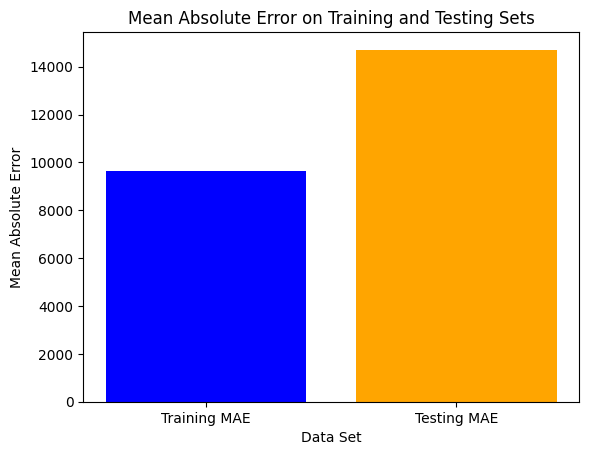

In [6]:
from sklearn.metrics import mean_absolute_error

# Evaluate the model using MAE
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f'Training MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

# Plot  MAE
mae_values = [train_mae, test_mae]
labels = ['Training MAE', 'Testing MAE']

plt.bar(labels, mae_values, color=['blue', 'orange'])
plt.xlabel('Data Set')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error on Training and Testing Sets')
plt.show()

### Simpan model dan lakukan percobaan

In [7]:
import joblib

# Save the trained model to a file
joblib.dump(rf_regressor, 'random_forest_model.pkl')

['randomforest_model.pkl']

In [13]:
# Load the trained Random Forest model
randomforest_model = joblib.load('random_forest_model.pkl')

# Use Random Forest model to make predictions
randomforest_predictions_test = randomforest_model.predict(x_test)

# Now you can use these predictions
print("Predictions:", randomforest_predictions_test[:10])
print("Actual Prices:", y_test[:10])

Predictions: [462077.4        540067.5        360076.333333   655632.846154
 506752.666667   559206.592593   395648.85986676 440055.
 620083.5        620130.        ]
Actual Prices: 21095    462077.400000
33631    540067.500000
29589    360076.333333
34856    655632.846154
49493    506752.666667
28452    559206.592593
28509    450049.400000
24414    440055.000000
45005    620083.500000
47107    620130.000000
Name: average_daily_rate, dtype: float64


In [18]:
# mendefinisi kolom yang memprediksi (xcol) dan diprediksi (ycol) 
predicted_column = df[['property_name', 
                       'room_id', 
                       'stay_duration_in_days', 
                       'booking_window', 
                       'distance_to_coastline', 
                       'lat',
                       'review_sentiment_score', 
                       'lng', 
                       'rating',
                       'average_daily_rate']]

In [20]:
predicted_column.head()

,property_name,room_id,stay_duration_in_days,booking_window,distance_to_coastline,lat,review_sentiment_score,lng,rating,average_daily_rate
0,Bingin Ombak,431874,4,81,15.6035,-8.805646,0.458603,115.113378,4.0,1.477799e+06
1,Bingin Ombak,431875,4,81,15.6035,-8.805646,0.458603,115.113378,4.0,1.477799e+06
2,Bingin Ombak,396658,4,81,15.6035,-8.805646,0.458603,115.113378,4.0,1.477799e+06
3,Bingin Ombak,396427,4,81,15.6035,-8.805646,0.455450,115.113378,4.0,1.477799e+06
4,Bingin Ombak,396427,4,81,15.6035,-8.805646,0.455450,115.113378,4.0,1.477799e+06


In [21]:
predicted_column.shape

(58903, 10)

In [22]:
distinct_data = predicted_column.drop_duplicates(subset=['property_name', 'room_id'])

In [25]:
distinct_data.shape

(184, 10)

In [26]:
distinct_data.to_csv('random_forest_distinct_data.csv', index=False)

In [38]:
import pandas as pd
from datetime import date
import joblib


def booking_window(today, check_in):
    return (check_in - today).days

def stay_duration(check_in, check_out):
    return (check_out - check_in).days

def predict(predicted_df, property_name, room_id, check_in, check_out):
    # Select property name and room_id
    filtered_df = predicted_df[(predicted_df['property_name'] == property_name) & 
                              (predicted_df['room_id'] == room_id)].copy()
    
    if filtered_df.empty:
        raise ValueError("No matching property_name and room_id found in the data")
    
    # Save the current price
    current_price = filtered_df['average_daily_rate'].values
    
    # Drop unnecessary columns
    filtered_df.drop(columns=['property_name', 'room_id', 'average_daily_rate'], inplace=True)
    
    # Feature engineering booking window
    today = date.today()
    booking_window_days = booking_window(today, check_in)
    
    # Feature engineering stay duration
    stay_duration_days = stay_duration(check_in, check_out)
    
    # Replace values in columns
    filtered_df['stay_duration_in_days'] = stay_duration_days
    filtered_df['booking_window'] = booking_window_days
    
    print("Booking window (days):", booking_window_days)
    print("Stay duration (days):", stay_duration_days)
    
    # Predict
    random_forest_model = joblib.load('random_forest_model.pkl')
    xgboost_predictions_test = random_forest_model.predict(filtered_df)
    
    return xgboost_predictions_test, current_price

def format_currency(value):
    value_str = f"{value:,.2f}"
    value_str = value_str.replace(',', 'X').replace('.', ',').replace('X', '.')
    return f"Rp {value_str}"

# Example usage
check_in = date(2024, 12, 1)
check_out = date(2024, 12, 30)

prediction, current_price = predict(distinct_data, 'Amazon Guesthouse', 397693, check_in, check_out)
formatted_current_price = format_currency(current_price[0])
formatted_prediction = format_currency(prediction[0])

print("Current Price:", formatted_current_price)
print("Prediction:", formatted_prediction)

Booking window (days): 176
Stay duration (days): 29
Current Price: Rp 446.768,58
Prediction: Rp 1.794.415,78
